In [239]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


In [240]:
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)

    # psf noise
    psf_noise= .001
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    
    if(version == 0):
        im += rng.normal(scale=noise, size=im.array.shape)
    if(version == 1):
        random = galsim.BaseDeviate(1024)
        var_image= im + noise
        varNoise = galsim.VariableGaussianNoise(random, var_image)
        im.addNoise(varNoise)
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    #factor*noise is to keep S/N between 10 and 1000
    if(version == 0):
        wt = imArr*0 + 1.0/(.54*noise)**2
    if(version == 1):
        wt = imArr*0 + 1.0/(0.0736*noise)**2
    
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [241]:
def analyze(rng, num_tests, num_gals, noise_level, shear_true):
    data = []
    x = []
    y = []
    shear_error = []
    s2n_error = []
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        for j in range(num_gals):
            obs = make_data(rng=rng, noise=noise_level[i], shear=shear_true)
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
        data.append(np.hstack(dlist))
        #data contains average of all galaxy data
        
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        
        s2n = data[i]['s2n'][w].mean()
        print ("s2n =", s2n)
        s2n_err = data[i]['s2n'][w].std(axis=0)/np.sqrt(w.size)
        s2n_error.append(s2n_err)
        
        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11
        print("shear[0] =", shear[0])
        
        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        #plt.hist(data[i]['g'][w][:,0])
        #assert 0==1
        shear_error.append(g_error[0]/R11)
        
        x.append(s2n)
        y.append(shear[0])
            
    return (x, y, s2n_error, shear_error)

In [242]:
rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

len(data[]) = 0
s2n = 1069.0057714542222
shear[0] = 0.029347507264411484
len(data[]) = 1
s2n = 335.96336532921225
shear[0] = 0.029676604485899892
len(data[]) = 2
s2n = 107.0233543257711
shear[0] = 0.026819313819510207
len(data[]) = 3
s2n = 33.21235317517201
shear[0] = 0.02493079238515193
len(data[]) = 4
s2n = 10.754692705667415
shear[0] = 0.03762648308098596
x = [1069.0057714542222, 335.96336532921225, 107.0233543257711, 33.21235317517201, 10.754692705667415]
y = [0.029347507264411484, 0.029676604485899892, 0.026819313819510207, 0.02493079238515193, 0.03762648308098596]
xerr = [6.116724005092924, 1.8115211475301352, 0.6471505603152921, 0.24254215808536336, 0.1406873791055465]
yerr = [0.0014635546682651294, 0.0018310038320092186, 0.003603037166394982, 0.00935481958372783, 0.02821970310226861]


Text(0, 0.5, '$g_{measured}$')

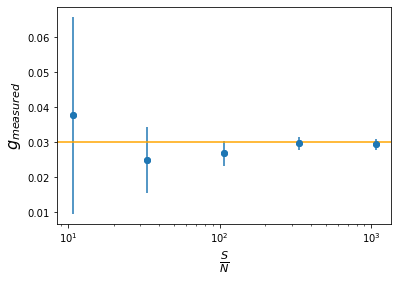

In [243]:
noise_arr = np.logspace(-4, -2, 5, base=10.0)
num_tests = len(noise_arr)
num_gals = 100
shear_true = [0.03, 0.00]
#version = 0: background noise only; version = 1: background and signal noise
version = 0
ans = analyze(rng, num_tests, num_gals, noise_arr, shear_true)
print("x =", ans[0])
print("y =", ans[1])
print("xerr =", ans[2])
print("yerr =", ans[3])

plt.errorbar(ans[0], ans[1], xerr=ans[2], yerr=ans[3], fmt='o')
plt.scatter(ans[0], ans[1])
plt.axhline(shear_true[0], color="orange")
plt.xscale("log")
plt.xlabel(r'$\frac{S}{N}$', fontsize=16)
plt.ylabel(r'$g_{measured}$', fontsize=16)

In [244]:
"""
im_noiseNormal = im
im_noiseVariable = im
galList.append(im_noiseNormal.array)
galList.append(im_noiseVariable.array)
galList.append(im.array)
for i in range(3):
    plt.imshow(galList[i])
    
plt.plot(im_noiseNormal)
plt.plot(im_noiseVariable.array)
plt.plot(im.array)

plt.show()
"""


def drawGal(pick):
    
    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    noise = 0.001
    random = galsim.BaseDeviate(1000)
    
    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,).shear(g1=0, g2=0,)
    
    
    obj0 = galsim.Exponential(half_light_radius=gal_hlr)
    
    obj = galsim.Convolve(psf, obj0)

    im = obj.drawImage(scale=scale)

    if(pick == 1):
        im += rng.normal(scale=noise, size=im.array.shape)
    if(pick == 2):
        var_image= im + noise
        varNoise = galsim.VariableGaussianNoise(random, var_image)
        im.addNoise(varNoise)
    return(plt.imshow(im.array))


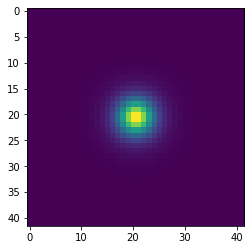

In [245]:
noise_type = 0
drawGal(noise_type)

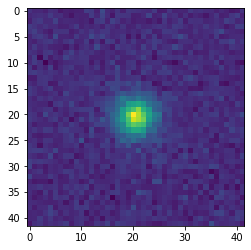

In [246]:
noise_type = 1
drawGal(noise_type)

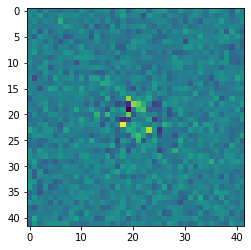

In [247]:
noise_type = 2
drawGal(noise_type)